# Rotational mechanical system

![The mechanical and electrical schematic for the mechanical system under consideration is shown. The Figure is from @Akbaba2022, licensed under Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 License.](rotational-mech-sys-fig-10-11.png){#fig-rotational-mech-sys-fig-10-11}

## Introduction

![Schematic](rotational-mech-sys.png){#fig-rotational-mech-sys}

### Circuit description


```
* C:\users\jeff64\My Documents\Electric circuit analog\rotational-mech-sys.asc
Va 1 0 1
VL 14 0 1
La 1 2 1
Lm 5 6 1
L1 7 8 1
L2 9 10 1
L5 0 10 1
L6 11 0 1
L3 11 12 1
L4 13 14 1
Ra 3 0 1
Rmb 5 4 1
R1 7 6 1
R4 13 12 1
C1 9 0 1
C2 12 0 1
Ha 2 3 V1 1
Hm 4 0 Va 1
V1 9 8 0
K1 L5 L6 0.5
.op
.backanno
.end
```

In [28]:
from sympy import *
import numpy as np
from tabulate import tabulate
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()

### Load the netlist
The netlist generated by LTSpice 

In [35]:
net_list = '''
Va 1 0 1
VL 14 0 1
La 1 2 1
Lm 5 6 1
L1 7 8 1
L2 9 10 1
L5 0 10 1
L6 11 0 1
L3 11 12 1
L4 13 14 1
Ra 3 0 1
Rmb 5 4 1
R1 7 6 1
R4 13 12 1
C1 9 0 1
C2 12 0 1
Ha 2 3 V1 1
Hm 4 0 Va 1
V1 9 8 0
K1 L5 L6 0.5
'''

Generate the network equations.

In [36]:
report, network_df, df2, A, X, Z = SymMNA.smna(net_list)

# Put matricies into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

In [37]:
print(report)

Net list report
number of lines in netlist: 20
number of branches: 19
number of nodes: 14
number of unknown currents: 13
number of RLC (passive components): 14
number of inductors: 8
number of independent voltage sources: 3
number of independent current sources: 0
number of op amps: 0
number of E - VCVS: 0
number of G - VCCS: 0
number of F - CCCS: 0
number of H - CCVS: 2
number of K - Coupled inductors: 1



Generate markdown text to display the network equations.

In [38]:
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*X)[i:i+1][0],Z[i])))

Markdown(temp)

$I_{La} + I_{Va} = 0$<br>$I_{Ha} - I_{La} = 0$<br>$- I_{Ha} + \frac{v_{3}}{Ra} = 0$<br>$I_{Hm} + \frac{v_{4}}{Rmb} - \frac{v_{5}}{Rmb} = 0$<br>$I_{Lm} - \frac{v_{4}}{Rmb} + \frac{v_{5}}{Rmb} = 0$<br>$- I_{Lm} + \frac{v_{6}}{R_{1}} - \frac{v_{7}}{R_{1}} = 0$<br>$I_{L1} - \frac{v_{6}}{R_{1}} + \frac{v_{7}}{R_{1}} = 0$<br>$- I_{L1} - I_{V1} = 0$<br>$C_{1} s v_{9} + I_{L2} + I_{V1} = 0$<br>$- I_{L2} - I_{L5} = 0$<br>$I_{L3} + I_{L6} = 0$<br>$- I_{L3} + v_{12} \left(C_{2} s + \frac{1}{R_{4}}\right) - \frac{v_{13}}{R_{4}} = 0$<br>$I_{L4} - \frac{v_{12}}{R_{4}} + \frac{v_{13}}{R_{4}} = 0$<br>$- I_{L4} + I_{Vl} = 0$<br>$v_{1} = Va$<br>$v_{14} = Vl$<br>$- v_{8} + v_{9} = V_{1}$<br>$- I_{La} La s + v_{1} - v_{2} = 0$<br>$- I_{Lm} Lm s + v_{5} - v_{6} = 0$<br>$- I_{L1} L_{1} s + v_{7} - v_{8} = 0$<br>$- I_{L2} L_{2} s - v_{10} + v_{9} = 0$<br>$- I_{L5} L_{5} s - I_{L6} M_{1} s - v_{10} = 0$<br>$- I_{L5} M_{1} s - I_{L6} L_{6} s + v_{11} = 0$<br>$- I_{L3} L_{3} s + v_{11} - v_{12} = 0$<br>$- I_{L4} L_{4} s + v_{13} - v_{14} = 0$<br>$- I_{V1} ha + v_{2} - v_{3} = 0$<br>$- I_{Va} hm + v_{4} = 0$<br>

As shown above MNA generated many equations and these would be difficult to solve by hand.

The sysmbols generated by the Python code are extraced by the SymPy function free_symbols and then declared as SymPy variables. 

In [39]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

### Symbolic solution
Since the circuit is large, a symbolic solution takes a long time, so code is commented out.

In [41]:
#U_sym = solve(NE_sym,X)

Display the symbolic solution

In [42]:
#temp = ''
#for i in U_sym.keys():
#    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

#Markdown(temp)

## Initial conditions
The SymPy Heaviside function is used to define the initial current and voltage on the inductor and capacitor.  

Built a dictionary of element values.

In [43]:
element_values = SymMNA.get_part_values(network_df)
element_values

The mutual inductance between L1 and L2 is calculated from the coupling coeeficient.

$M = k\sqrt{L_1L_2}$

In [44]:
K1 = symbols('K1')

# calculate the coupling constant from the mutual inductance
element_values[M1] = element_values[K1]*np.sqrt(element_values[L5] * element_values[L6])
print('mutual inductance, M1 = {:.9f}'.format(element_values[M1]))

mutual inductance, M1 = 0.500000000


In [45]:
t = symbols('t',positive=True)  # t > 0

In [50]:
element_values[V1] = laplace_transform(12*Heaviside(t), t, s)[0]
#element_values[V2] = laplace_transform(0.0104*Heaviside(t), t, s)[0]
NE = NE_sym.subs(element_values)
NE

                                    ⎡ 0 ⎤
⎡          I_La + I_Va          ⎤   ⎢   ⎥
⎢                               ⎥   ⎢ 0 ⎥
⎢          I_Ha - I_La          ⎥   ⎢   ⎥
⎢                               ⎥   ⎢ 0 ⎥
⎢        -I_Ha + 1.0⋅v₃         ⎥   ⎢   ⎥
⎢                               ⎥   ⎢ 0 ⎥
⎢      I_Hm + 1.0⋅v₄ - v₅       ⎥   ⎢   ⎥
⎢                               ⎥   ⎢ 0 ⎥
⎢      I_Lm - v₄ + 1.0⋅v₅       ⎥   ⎢   ⎥
⎢                               ⎥   ⎢ 0 ⎥
⎢      -I_Lm + 1.0⋅v₆ - v₇      ⎥   ⎢   ⎥
⎢                               ⎥   ⎢ 0 ⎥
⎢      I_L1 - v₆ + 1.0⋅v₇       ⎥   ⎢   ⎥
⎢                               ⎥   ⎢ 0 ⎥
⎢         -I_L1 - I_V1          ⎥   ⎢   ⎥
⎢                               ⎥   ⎢ 0 ⎥
⎢    I_L2 + I_V1 + 1.0⋅s⋅v₉     ⎥   ⎢   ⎥
⎢                               ⎥   ⎢ 0 ⎥
⎢         -I_L2 - I_L5          ⎥   ⎢   ⎥
⎢                               ⎥   ⎢ 0 ⎥
⎢          I_L3 + I_L6          ⎥   ⎢   ⎥
⎢                               ⎥   ⎢ 0 ⎥
⎢-I_L3 + v₁₂⋅(1.0⋅s + 1.0) - v₁₃⎥ 

In [51]:
U = solve(NE,X)

temp = ''
for i in U_ic.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_ic[i]))

Markdown(temp)

$v_{1} = 1.0$<br>$v_{2} = \frac{30.0 s^{6} - 105.0 s^{5} - 58.0 s^{4} - 232.0 s^{3} - 99.0 s^{2} - 92.0 s - 36.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$v_{3} = \frac{30.0 s^{7} + 60.0 s^{6} + 287.0 s^{5} + 289.0 s^{4} + 451.0 s^{3} + 234.0 s^{2} + 152.0 s + 48.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$v_{4} = \frac{- 30.0 s^{7} - 60.0 s^{6} - 287.0 s^{5} - 289.0 s^{4} - 451.0 s^{3} - 234.0 s^{2} - 152.0 s - 48.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$v_{5} = \frac{- 30.0 s^{7} - 225.0 s^{6} - 632.0 s^{5} - 810.0 s^{4} - 1001.0 s^{3} - 560.0 s^{2} - 340.0 s - 96.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$v_{6} = \frac{- 195.0 s^{7} - 570.0 s^{6} - 1153.0 s^{5} - 1360.0 s^{4} - 1327.0 s^{3} - 748.0 s^{2} - 388.0 s - 96.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$v_{7} = \frac{- 195.0 s^{7} - 735.0 s^{6} - 1498.0 s^{5} - 1881.0 s^{4} - 1877.0 s^{3} - 1074.0 s^{2} - 576.0 s - 144.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$v_{8} = \frac{- 360.0 s^{7} - 1080.0 s^{6} - 2019.0 s^{5} - 2431.0 s^{4} - 2203.0 s^{3} - 1262.0 s^{2} - 624.0 s - 144.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$v_{9} = \frac{165.0 s^{4} + 341.0 s^{3} + 425.0 s^{2} + 358.0 s + 96.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$v_{10} = \frac{- 4.0 s^{5} + 69.0 s^{4} + 149.0 s^{3} + 195.0 s^{2} + 170.0 s + 48.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$v_{11} = \frac{14.0 s^{5} + 6.0 s^{4} - 10.0 s^{3} - 45.0 s^{2} - 58.0 s - 24.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$v_{12} = \frac{30.0 s^{5} + 60.0 s^{4} + 76.0 s^{3} + 25.0 s^{2} - 22.0 s - 24.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$v_{13} = \frac{30.0 s^{6} + 90.0 s^{5} + 152.0 s^{4} + 155.0 s^{3} + 89.0 s^{2} + 24.0 s + 12.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$v_{14} = 1.0$<br>$I_{Va} = \frac{- 30.0 s^{7} - 60.0 s^{6} - 287.0 s^{5} - 289.0 s^{4} - 451.0 s^{3} - 234.0 s^{2} - 152.0 s - 48.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$I_{Vl} = \frac{- 30.0 s^{6} - 60.0 s^{5} - 92.0 s^{4} - 79.0 s^{3} - 64.0 s^{2} - 46.0 s - 36.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$I_{V1} = \frac{- 165.0 s^{6} - 345.0 s^{5} - 521.0 s^{4} - 550.0 s^{3} - 326.0 s^{2} - 188.0 s - 48.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$I_{La} = \frac{30.0 s^{7} + 60.0 s^{6} + 287.0 s^{5} + 289.0 s^{4} + 451.0 s^{3} + 234.0 s^{2} + 152.0 s + 48.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$I_{Lm} = \frac{165.0 s^{6} + 345.0 s^{5} + 521.0 s^{4} + 550.0 s^{3} + 326.0 s^{2} + 188.0 s + 48.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$I_{L1} = \frac{165.0 s^{6} + 345.0 s^{5} + 521.0 s^{4} + 550.0 s^{3} + 326.0 s^{2} + 188.0 s + 48.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$I_{L2} = \frac{4.0 s^{5} + 96.0 s^{4} + 192.0 s^{3} + 230.0 s^{2} + 188.0 s + 48.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$I_{L5} = \frac{- 4.0 s^{5} - 96.0 s^{4} - 192.0 s^{3} - 230.0 s^{2} - 188.0 s - 48.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$I_{L6} = \frac{16.0 s^{4} + 54.0 s^{3} + 86.0 s^{2} + 70.0 s + 36.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$I_{L3} = \frac{- 16.0 s^{4} - 54.0 s^{3} - 86.0 s^{2} - 70.0 s - 36.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$I_{L4} = \frac{- 30.0 s^{6} - 60.0 s^{5} - 92.0 s^{4} - 79.0 s^{3} - 64.0 s^{2} - 46.0 s - 36.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$I_{Ha} = \frac{30.0 s^{7} + 60.0 s^{6} + 287.0 s^{5} + 289.0 s^{4} + 451.0 s^{3} + 234.0 s^{2} + 152.0 s + 48.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$I_{Hm} = \frac{- 165.0 s^{6} - 345.0 s^{5} - 521.0 s^{4} - 550.0 s^{3} - 326.0 s^{2} - 188.0 s - 48.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>

## Inductor current

### L1 current
L1 current is equalivent to displacement. The current through L1 is symplified with the chain of operators applied to the expression; [nsimplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#sympy.simplify.simplify.nsimplify), [simplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#simplify), [expand()](https://docs.sympy.org/latest/modules/core.html#sympy.core.function.expand) and [together()](https://docs.sympy.org/latest/modules/polys/reference.html#sympy.polys.rationaltools.together). This helps SymPy solve the inverse Laplace transform.

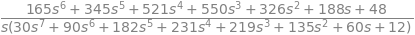

In [52]:
L1_current_s = U[I_L1].nsimplify().simplify().expand().together()
L1_current_s

The inverse Laplace was taking too long, so the lines of code were commented out

In [53]:
#L1_current = inverse_laplace_transform(L1_current_s, s, t)
#L1_current

Using NumPy to obtain the partial fraction expansion, convert back to the s domain and then take the inverse Laplace transform on each term.

Extract the numerator and denominator and display.

In [54]:
n, d = fraction(L1_current_s)
n = n.expand()
Markdown('numerator: ${:s}$<br>denominator: ${:s}$'.format(latex(n),latex(d)))

numerator: $165 s^{6} + 345 s^{5} + 521 s^{4} + 550 s^{3} + 326 s^{2} + 188 s + 48$<br>denominator: $s \left(30 s^{7} + 90 s^{6} + 182 s^{5} + 231 s^{4} + 219 s^{3} + 135 s^{2} + 60 s + 12\right)$

Each of the numerator terms can be put over the common denominator.

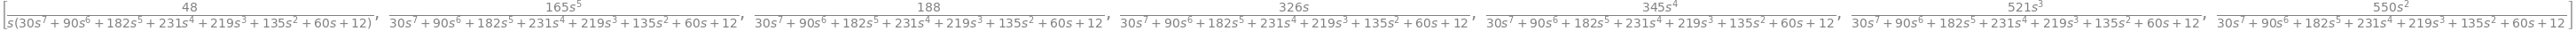

In [55]:
terms = [a / d for a in n.args]
display(terms)

The following code processes each of the terms obtained above. 

- the SciPy function [residue](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.residue.html) is used to get the residues and poles of the partial-fraction expansion
- build the partial expansion terms and find the inverse Laplace of each term and save

Returns:

- r: Residues corresponding to the poles. For repeated poles, the residues are ordered to correspond to ascending by power fractions.
- p: Poles ordered by magnitude in ascending order.
- k: Coefficients of the direct polynomial term.

When computing the inverse Laplace transform, the Coefficients (k) are ignored since these transform to a Dirac delta function, $\delta (t)$ and don't need to be plotted.

In [56]:
N = []

for p1 in terms:

    # use the SciPy residue function to get the partial-fraction expansion residues and poles
    n, d = fraction(p1)
    cn = Poly(n, s).all_coeffs()
    cd = Poly(d, s).all_coeffs()
    r, p, k = signal.residue(cn, cd, tol=0.001, rtype='avg')

    # build a symbolic expression for each of the residues and find the inverse Laplace of each one and save
    z = 0
    for i in range(len(r)):
        m = (r[i]/(s-p[i]))
        z += inverse_laplace_transform(m, s, t)

    N.append(z)

Each of these terms came be converted to a function using SymPy's [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html) function.

Define the values for the x-axis of the plot and put each one into an array for plotting.

In [57]:
x = np.linspace(0, 50, 2000, endpoint=True)
V_node2 = np.zeros(len(x),dtype = complex)
for p in N:
    V_node2 += lambdify(t, p)(x)

Plot the final combined result.

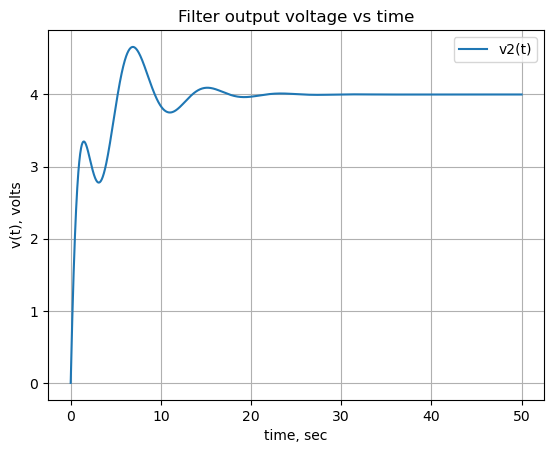

In [58]:
plt.title('Filter output voltage vs time')

plt.plot(x, np.real(V_node2),label='v2(t)')
#plt.plot(x, np.real(func_V1_t(x)),label='V1(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

### L4 current
L1 current is equalivent to displacement. The current through L1 is symplified with the chain of operators applied to the expression; [nsimplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#sympy.simplify.simplify.nsimplify), [simplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#simplify), [expand()](https://docs.sympy.org/latest/modules/core.html#sympy.core.function.expand) and [together()](https://docs.sympy.org/latest/modules/polys/reference.html#sympy.polys.rationaltools.together). This helps SymPy solve the inverse Laplace transform.

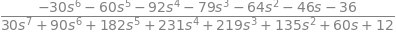

In [59]:
L4_current_s = U[I_L4].nsimplify().simplify().expand().together()
L4_current_s

The inverse Laplace was taking too long, so the lines of code were commented out

In [60]:
#L4_current = inverse_laplace_transform(L4_current_s, s, t)
#L4_current

Using NumPy to obtain the partial fraction expansion, convert back to the s domain and then take the inverse Laplace transform on each term.

Extract the numerator and denominator and display.

In [61]:
n, d = fraction(L4_current_s)
n = n.expand()
Markdown('numerator: ${:s}$<br>denominator: ${:s}$'.format(latex(n),latex(d)))

numerator: $- 30 s^{6} - 60 s^{5} - 92 s^{4} - 79 s^{3} - 64 s^{2} - 46 s - 36$<br>denominator: $30 s^{7} + 90 s^{6} + 182 s^{5} + 231 s^{4} + 219 s^{3} + 135 s^{2} + 60 s + 12$

Each of the numerator terms can be put over the common denominator.

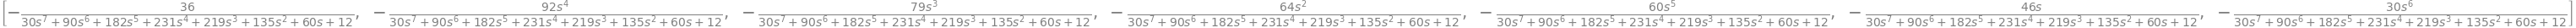

In [62]:
terms = [a / d for a in n.args]
display(terms)

The following code processes each of the terms obtained above. 

- the SciPy function [residue](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.residue.html) is used to get the residues and poles of the partial-fraction expansion
- build the partial expansion terms and find the inverse Laplace of each term and save

Returns:

- r: Residues corresponding to the poles. For repeated poles, the residues are ordered to correspond to ascending by power fractions.
- p: Poles ordered by magnitude in ascending order.
- k: Coefficients of the direct polynomial term.

When computing the inverse Laplace transform, the Coefficients (k) are ignored since these transform to a Dirac delta function, $\delta (t)$ and don't need to be plotted.

In [63]:
N = []

for p1 in terms:

    # use the SciPy residue function to get the partial-fraction expansion residues and poles
    n, d = fraction(p1)
    cn = Poly(n, s).all_coeffs()
    cd = Poly(d, s).all_coeffs()
    r, p, k = signal.residue(cn, cd, tol=0.001, rtype='avg')

    # build a symbolic expression for each of the residues and find the inverse Laplace of each one and save
    z = 0
    for i in range(len(r)):
        m = (r[i]/(s-p[i]))
        z += inverse_laplace_transform(m, s, t)

    N.append(z)

Each of these terms came be converted to a function using SymPy's [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html) function.

Define the values for the x-axis of the plot and put each one into an array for plotting.

In [64]:
x = np.linspace(0, 50, 2000, endpoint=True)
V_node2 = np.zeros(len(x),dtype = complex)
for p in N:
    V_node2 += lambdify(t, p)(x)

Plot the final combined result.

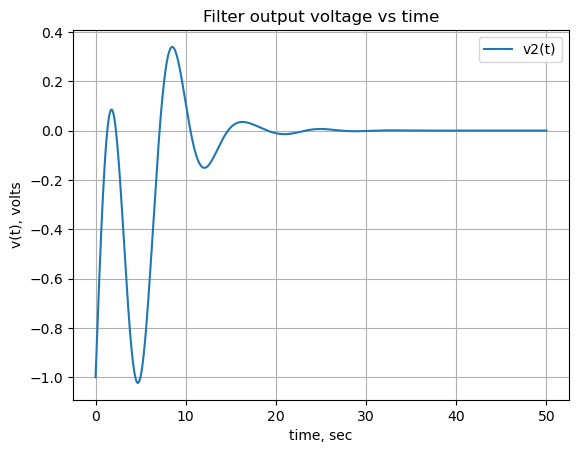

In [65]:
plt.title('Filter output voltage vs time')

plt.plot(x, np.real(V_node2),label='v2(t)')
#plt.plot(x, np.real(func_V1_t(x)),label='V1(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()